In [50]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [51]:
batch_size = 16
img_height = 128
img_width = 128

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [52]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

Define some parameters for the loader:

In [53]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [54]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [55]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
(32, 128, 128, 3)
(32,)


In [56]:
# Normalize data
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.9996937


In [57]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)

In [61]:
model = Sequential([
  data_augmentation,
  #layers.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(128, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

## Compile and train the model

In [62]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [64]:
epochs = 100
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callback]
)

Epoch 1/100
92/92 [==============================] - 9s 102ms/step - loss: 1.0337 - accuracy: 0.5899 - val_loss: 1.0516 - val_accuracy: 0.5845
Epoch 2/100
92/92 [==============================] - 12s 125ms/step - loss: 1.0346 - accuracy: 0.5851 - val_loss: 1.1006 - val_accuracy: 0.5504
Epoch 3/100
92/92 [==============================] - 12s 125ms/step - loss: 1.0273 - accuracy: 0.5780 - val_loss: 1.0326 - val_accuracy: 0.5940
Epoch 4/100
92/92 [==============================] - 12s 125ms/step - loss: 1.0430 - accuracy: 0.5862 - val_loss: 1.0598 - val_accuracy: 0.5913
Epoch 5/100
92/92 [==============================] - 12s 125ms/step - loss: 1.0222 - accuracy: 0.5903 - val_loss: 0.9837 - val_accuracy: 0.6226
Epoch 6/100
92/92 [==============================] - 12s 126ms/step - loss: 1.0217 - accuracy: 0.5889 - val_loss: 1.0090 - val_accuracy: 0.6104
Epoch 7/100
92/92 [==============================] - 12s 125ms/step - loss: 1.0227 - accuracy: 0.5841 - val_loss: 1.0221 - val_accuracy: 

In [49]:
model.save('model/simple_classifier')

INFO:tensorflow:Assets written to: model/simple_classifier/assets


## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

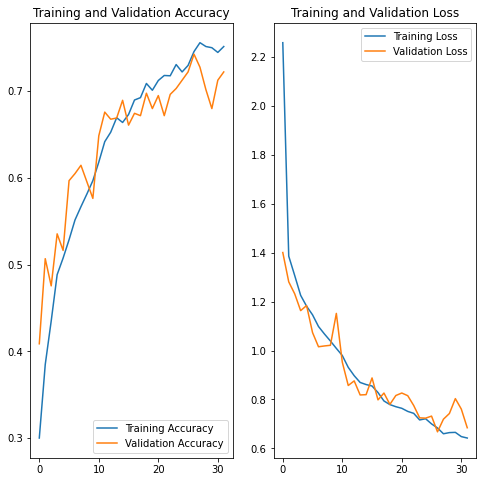

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(32)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

131072/117948 [=================================] - 0s 0us/step
This image most likely belongs to tulips with a 72.57 percent confidence.


<h2>
Transfer Learning
</h2>

In [ ]:
# Flower data for training 
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_dipassrectory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
# Transfer Learning InceptionV3 model

inception = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(img_width,img_height,3), pooling=None, classes=None,
    classifier_activation='softmax'
)
inception.trainable = False

"""global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)"""

data_augmentation = keras.Sequential(
            [
                layers.RandomFlip("horizontal",
                                    input_shape=(
                                                    img_height,
                                                    img_width,
                                                    3
                                                )
                                ),
                layers.RandomFlip('horizontal'),
                layers.RandomRotation(0.2),
                layers.RandomZoom(0.1),
                layers.Rescaling(1./255),
            ]
        )


inputs = tf.keras.Input(shape=(img_width, img_height, 3))
x = data_augmentation(inputs)

x = inception(x, training=False)
#x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=batch_size
)